In [1]:
#-*- coding: utf-8 -*-

import tensorflow as tf
# dont display much info of tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any level you prefer

# limit gpu memory usage only as much as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        print("Setting memory growth to True for GPU: ", gpu)
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print("Physical GPUs: ", len(gpus), "Logical GPUs: ", len(logical_gpus))
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Concatenate, Add, AveragePooling2D
import numpy as np

import matplotlib.pyplot as plt


2024-01-04 10:35:00.226871: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-04 10:35:00.325568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 10:35:00.325638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 10:35:00.329599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 10:35:00.350575: I tensorflow/core/platform/cpu_feature_guar

Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Physical GPUs:  1 Logical GPUs:  1


In [2]:

# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path)
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

#feats = np.load(feats_path)
#print("feats shape: ", feats.shape)
y = y[:, 0] # only use laser power
print("y shape: ", y.shape)

# normalize y
y = y / np.max(y)

manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
y shape:  (9587,)


In [3]:
# unique values in y
y_unique = np.unique(y)
print("unique values in y: ", y_unique)

# encode y as integers based on unique values
y_encoded = np.zeros(y.shape)
for i in range(len(y_unique)):
    y_encoded[y == y_unique[i]] = i
print("y encoded: ", y_encoded)
# change to int
y_encoded = y_encoded.astype(int)

# print typr of y_encoded
print("y encoded type: ", type(y_encoded[0]))

unique values in y:  [0.18181818 0.45454545 0.72727273 1.        ]
y encoded:  [0. 0. 0. ... 3. 3. 3.]
y encoded type:  <class 'numpy.int64'>


In [4]:
# crate pairs
def create_pairs(manta, xiris, y_encoded):
    # set seed
    np.random.seed(42)
        
    pairs = []
    labels = []
    binary_labels = []
    
    # Getting the indices of each class
    numclasses = len(np.unique(y_encoded))
    idx = [np.where(y_encoded==i)[0] for i in range(numclasses)]

    for idxA in range(len(y_encoded)):
        # grab the current image and label belonging to the current iteration
        currentImage = manta[idxA]
        label1 = y_encoded[idxA]

        # randomly pick an image that belongs to the same class label
        idxB = np.random.choice(idx[label1])
        posImage = xiris[idxB]

        # prepare a positive pair and update the images and labels lists, respectively
        pairs.append([currentImage, posImage])
        labels.append([label1, label1])
        binary_labels.append([0])

        # grab the indices for each of the class labels not equal to the current label
        negIdx = np.where(y_encoded != label1)[0]
        
        # randomly pick an image corresponding to a label not equal to the current label
        idxC = np.random.choice(negIdx)
        label2 = y_encoded[idxC]
        negImage = xiris[idxC]
        
        # prepare a negative pair of images and update our lists
        pairs.append([currentImage, negImage])
        labels.append([label1, label2])
        binary_labels.append([1])

        if idxA % 1000 == 0:
            print(f"Creating pairs for image {idxA}/{len(y_encoded)}, Completed {int(idxA/len(y_encoded)*100)}%")
    
    return np.array(pairs), np.array(labels), np.array(binary_labels)      
                                                                                             
# create pairs
pairs, labels, binary_labels = create_pairs(manta, xiris, y_encoded)
print("pairs shape: ", pairs.shape)
print("labels shape: ", labels.shape)

# split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pairs, binary_labels, test_size=0.2, random_state=42, shuffle=True)
print(f"X_train shape: {X_train.shape} ",f"y_train shape: {y_train.shape} ")
print(f"X_test shape: {X_test.shape} ",f"y_test shape: {y_test.shape} ")

# max and min of y_train and y_test
print("max of y_train: ", np.max(y_train))
print("min of y_train: ", np.min(y_train))

print("max of y_test: ", np.max(y_test))
print("min of y_test: ", np.min(y_test))


Creating pairs for image 0/9587, Completed 0%
Creating pairs for image 1000/9587, Completed 10%
Creating pairs for image 2000/9587, Completed 20%
Creating pairs for image 3000/9587, Completed 31%
Creating pairs for image 4000/9587, Completed 41%
Creating pairs for image 5000/9587, Completed 52%
Creating pairs for image 6000/9587, Completed 62%
Creating pairs for image 7000/9587, Completed 73%
Creating pairs for image 8000/9587, Completed 83%
Creating pairs for image 9000/9587, Completed 93%


In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(pairs, labels, test_size=0.2, random_state=42, shuffle=True)

: 

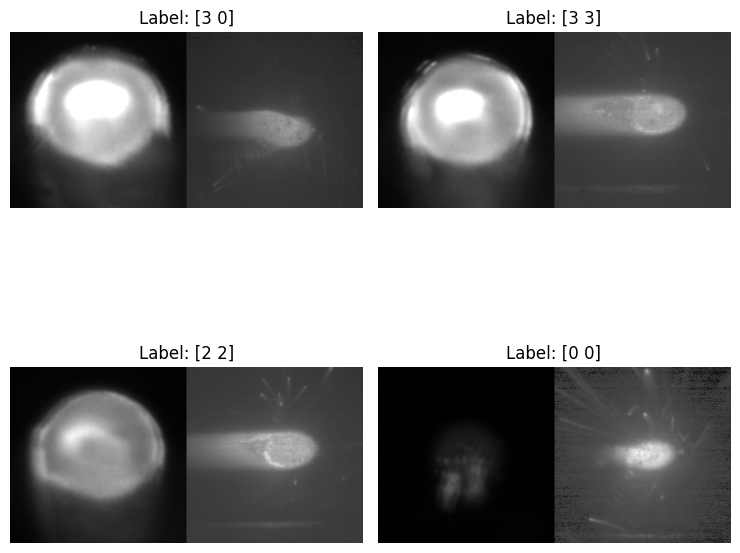

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.keras.layers.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

# visualize pairs
visualize(X_train2, y_train2, to_show=4, num_col=2)

In [ ]:
def contrastive_loss_with_margin(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        # Ensure that y_true is of type float32
        y_true = tf.cast(y_true, dtype=tf.float32)

        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

def accuracy(y_true, y_pred):
    """
    Compute classification accuracy with a fixed threshold on distances.
    """
    return tf.reduce_mean(tf.cast(tf.equal((y_true), tf.cast(y_pred < 0.5, y_true.dtype)), tf.float32))


In [ ]:
def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# add projection head
def add_projection_head(input_shape, encoder, embedding_dim):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)
    outputs = Dense(embedding_dim, activation='relu')(features)
    model = Model(inputs=inputs, outputs=outputs)
    return model


def contrastive_loss_2(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    x =  tf.cast(y_true[:,0], dtype=tf.float32)
    #print("x: ", x)
    y =  tf.cast(y_true[:,1], dtype=tf.float32)
    #print("y: ", y)
    z = tf.abs(tf.subtract(x, y))
    #print("z: ", z)
    # using tf less to construct binary labels
    y_b = tf.cast(tf.less(z, 1), tf.float32)

    margin = 0.5
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean((1 - y_b) * square_pred + (y_b) * margin_square)

# get first 4 values of y_train2
y_true2 = y_train2[:4, :]

# test contrastive_loss_2
y_true = np.array([[0, 0], [2, 1], [0, 3], [3, 3]])
y_pred = np.array([0.09, 0.85, 0.95, 0.92])

print(contrastive_loss_2(y_true2, y_pred))

2024-01-03 17:17:23.205859: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


tf.Tensor(0.002025, shape=(), dtype=float32)


In [ ]:
y_true2

array([[3, 0],
       [3, 3],
       [2, 2],
       [0, 0]])

In [ ]:
def accuracy_2(y_true, y_pred):
    """
    Compute classification accuracy with a fixed threshold on distances.
    """
    x =  tf.cast(y_true[:,0], dtype=tf.float32)
    #print("x: ", x)
    y =  tf.cast(y_true[:,1], dtype=tf.float32)
    #print("y: ", y)
    z = tf.abs(tf.subtract(x, y))
    #print("z: ", z)
    # using tf less to construct binary labels
    y_b = tf.cast(tf.less(z, 1), tf.float32)
    
    return tf.reduce_mean(tf.cast(tf.equal((y_b), tf.cast(y_pred < 0.5, y_b.dtype)), tf.float32))

# test accuracy_2
y_true = np.array([[0, 0], [2, 1], [0, 3], [3, 3]])
y_pred = np.array([0.9, 0.85, 0.95, 0.92])

print(accuracy_2(y_true2, y_pred))

tf.Tensor(0.25, shape=(), dtype=float32)


In [ ]:
y_train2.shape

(15339, 2)

In [ ]:
y_train.shape

(15339, 1)

In [ ]:
#accuracy3 = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

def accuracy_3(y_true, y_pred):
    """
    Compute classification accuracy with a fixed threshold on distances.
    """
    threshold = 0.5
    return tf.reduce_mean(tf.cast(tf.abs(y_true - y_pred) < threshold, tf.float32))
    #return tf.reduce_mean(tf.cast(tf.equal((y_true), tf.cast(y_pred, y_true.dtype)), tf.float32))

In [ ]:
input_shape = (320, 320, 1)
embedding_dim= 128
batch_size = 64
epochs = 10
learning_rate = 0.001

encoder = create_encoder(input_shape)
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim)

manta = Input(shape=input_shape)
xiris = Input(shape=input_shape)
manta_encoded = encoder_with_projection_head(manta)
xiris_encoded = encoder_with_projection_head(xiris)
# Assuming encoded_l and encoded_r are your two input tensors
distance = tf.abs(manta_encoded - xiris_encoded)
output = tf.keras.layers.Dense(1, activation="linear")(distance)

siamese_net = tf.keras.Model(inputs=[manta, xiris], outputs=output)

siamese_net.compile(loss=contrastive_loss_with_margin(margin=1), #contrastive_loss_2,  #contrastive_loss_with_margin2(margin=1.0)
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                    metrics=[accuracy_3]) # accuracy #'accuracy'

siamese_net.summary()
history = siamese_net.fit(
    [X_train[:, 0], X_train[:, 1]],
    # only the first two columns of y_train are needed
    y_train, #y_train2,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 128)                  2492499   ['input_3[0][0]',             
                                                          2          'input_4[0][0]']             
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 128)                  0         ['model_1[0][0]',       

: 

In [ ]:
# del model siamese_net
#del siamese_net